In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray as xr
import xbout
from pathlib import Path
import xhermes as xh

sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/sdtools"))
sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/my_notebooks/notebooks/hermes-3/transients"))

from plotting_functions import *

from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.fluxes import *


# plt.style.use('ggplot')
plt.rcParams.update({'font.size': 10})
linewidth = 3
markersize = 15



# plt.style.use('ggplot')
plt.style.use('default')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 16})



%load_ext autoreload
%autoreload 2


In [2]:
ds_fl = xh.open('/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/2024-09_glimmer_steady_state_base/FL/SXD/case_01')

ValueError: cannot align objects with join='exact' where index/labels/sizes are not equal along these coordinates (dimensions): 't' ('t',)

In [8]:
print(ds_fl['Div_Q_SH'])

<xarray.DataArray 'Div_Q_SH' (t: 7, x: 1, y: 400, z: 1)>
dask.array<mul, shape=(7, 1, 400, 1), dtype=float64, chunksize=(7, 1, 10, 1), chunktype=numpy.ndarray>
Coordinates:
    dx       (x, y) float64 dask.array<chunksize=(1, 10), meta=np.ndarray>
    dy       (x, y) float64 dask.array<chunksize=(1, 10), meta=np.ndarray>
    dz       (x, y) float64 dask.array<chunksize=(1, 10), meta=np.ndarray>
  * t        (t) float64 0.0 5e+05 1e+06 1.5e+06 2e+06 2.5e+06 3e+06
  * x        (x) int64 0
  * y        (y) float64 0.1661 0.4978 0.8287 1.159 ... 69.93 69.95 69.97 69.99
  * z        (z) float64 3.142
Attributes:
    current_time_index:  7
    cell_location:       CELL_CENTRE
    conversion:          15346982899.153515
    direction_y:         Standard
    direction_z:         Standard
    long_name:           Divergence of Spitzer-Harm electron heat conduction
    source:              snb_conduction
    time_dimension:      t
    units:               W / m^3
    metadata:            {'BOUT_

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def replace_guards(var):
    """
    This in-place replaces the points in the guard cells with the points 
    on the boundary.
    """
    var = var[1:-1]  # Strip the edge guard cells

    var[0] = 0.5 * (var[0] + var[1])
    var[-1] = 0.5 * (var[-1] + var[-2])
    
    return var


def plot_latest_profiles(dataset):
    """
    Plots the latest time step profiles for electron and ion temperature,
    electron and neutral density.

    Parameters:
    dataset (xarray Dataset): Hermes-3 dataset.
    """
    # Select the latest time step
    latest = dataset.isel(t=-1)
    
    # Variables to plot
    y = latest['y'].values
    Te = np.ravel(latest['Te'].values)
    Td_plus = np.ravel(latest['Td+'].values)
    Ne = np.ravel(latest['Ne'].values)
    Nd = np.ravel(latest['Nd'].values)

    # Remove guard cells
    y = y[1:-1]
    Te = replace_guards(Te)
    Td_plus = replace_guards(Td_plus)
    Ne = replace_guards(Ne)
    Nd = replace_guards(Nd)

    # Create figure for profiles
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.flatten()

    axs[0].plot(y, Te, label='Te (eV)')
    axs[0].set_title('Electron Temperature (Te)')
    axs[0].set_xlabel('Distance along y (m)')
    axs[0].set_ylabel('Te (eV)')

    axs[1].plot(y, Td_plus, label='Td+ (eV)')
    axs[1].set_title('Ion Temperature (Td+)')
    axs[1].set_xlabel('Distance along y (m)')
    axs[1].set_ylabel('Td+ (eV)')

    axs[2].plot(y, Ne, label='Ne (m^-3)')
    axs[2].set_title('Electron Density (Ne)')
    axs[2].set_xlabel('Distance along y (m)')
    axs[2].set_yscale('log')
    axs[2].set_ylabel('Ne (m^-3)')

    axs[3].plot(y, Nd, label='Nd (m^-3)')
    axs[3].set_title('Neutral Density (Nd)')
    axs[3].set_xlabel('Distance along y (m)')
    axs[3].set_yscale('log')
    axs[3].set_ylabel('Nd (m^-3)')

    for ax in axs:
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()


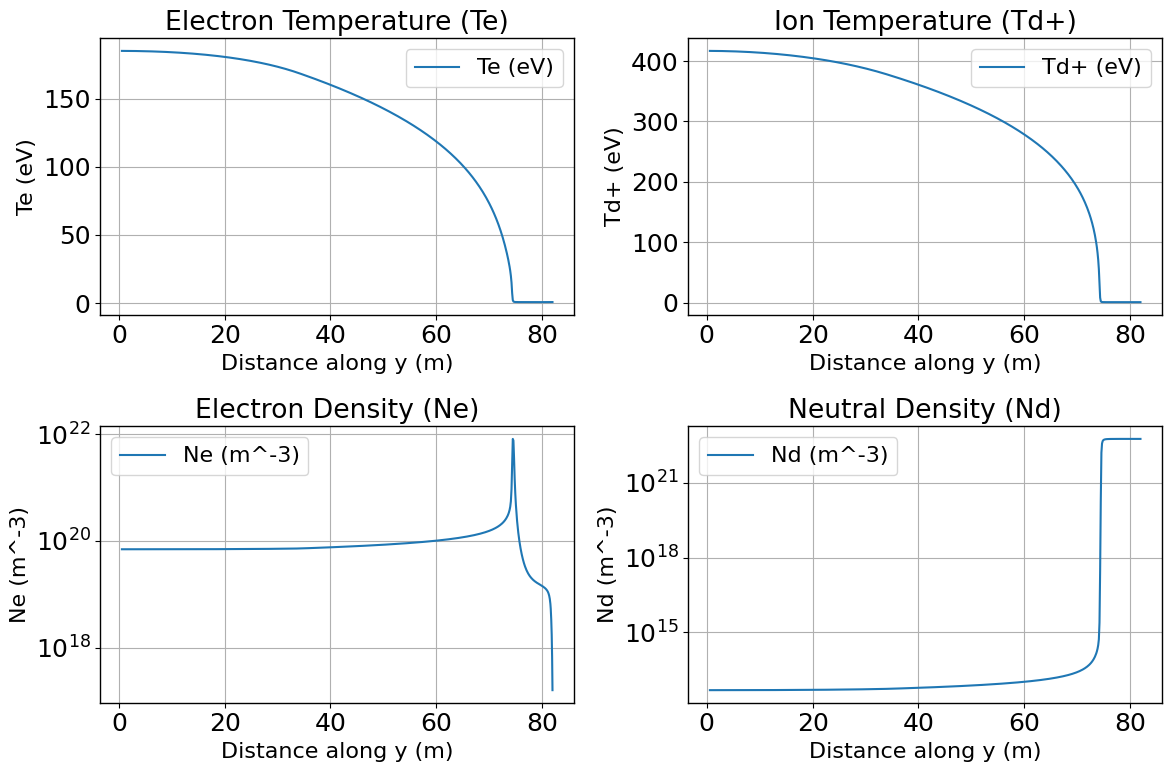

In [9]:
plot_latest_profiles(ds_fl)

In [5]:
def plot_time_history(dataset):
    """
    Plots the time history of upstream and target temperatures and densities,
    using the last 200 time slices or the maximum available.

    Parameters:
    dataset (xarray Dataset): Hermes-3 dataset.
    """
    # Determine how many time steps to plot (maximum 200 or the total available)
    num_time_slices = min(200, dataset.sizes['t'])
    
    # Select the last `num_time_slices` time steps
    selected_steps = dataset.isel(t=slice(-num_time_slices, None))
    
    # Extract upstream and target data
    # Assuming upstream corresponds to first non-guard cell and target to the last cell
    upstream_index = 2  # First non-guard cell
    target_index = -2  # Target cell

    times = selected_steps['t'].values  # Corresponding time values

    upstream_data = {
        "Te": np.squeeze(selected_steps['Te'].isel(y=upstream_index).values),
        "Td+": np.squeeze(selected_steps['Td+'].isel(y=upstream_index).values),
        "Ne": np.squeeze(selected_steps['Ne'].isel(y=upstream_index).values)
    }

    target_data = {
        "Te": np.squeeze(selected_steps['Te'].isel(y=target_index).values),
        "Td+": np.squeeze(selected_steps['Td+'].isel(y=target_index).values),
        "Ne": np.squeeze(selected_steps['Ne'].isel(y=target_index).values)
    }

    # Plot time history for upstream and target values
    fig, axs = plt.subplots(2, 3, figsize=(14, 8))
    axs = axs.flatten()

    # Plot upstream values
    axs[0].plot(times, upstream_data["Te"], marker='o')
    axs[0].set_title('Upstream Te (eV)')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Te (eV)')

    axs[1].plot(times, upstream_data["Td+"], marker='o')
    axs[1].set_title('Upstream Td+ (eV)')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Td+ (eV)')

    axs[2].plot(times, upstream_data["Ne"], marker='o')
    axs[2].set_title('Upstream Ne (m^-3)')
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('Ne (m^-3)')

    # Plot target values
    axs[3].plot(times, target_data["Te"], marker='o')
    axs[3].set_title('Target Te (eV)')
    axs[3].set_xlabel('Time')
    axs[3].set_ylabel('Te (eV)')

    axs[4].plot(times, target_data["Td+"], marker='o')
    axs[4].set_title('Target Td+ (eV)')
    axs[4].set_xlabel('Time')
    axs[4].set_ylabel('Td+ (eV)')

    axs[5].plot(times, target_data["Ne"], marker='o')
    axs[5].set_title('Target Ne (m^-3)')
    axs[5].set_xlabel('Time')
    axs[5].set_ylabel('Ne (m^-3)')

    for ax in axs:
        ax.grid(True)

    plt.tight_layout()
    plt.show()



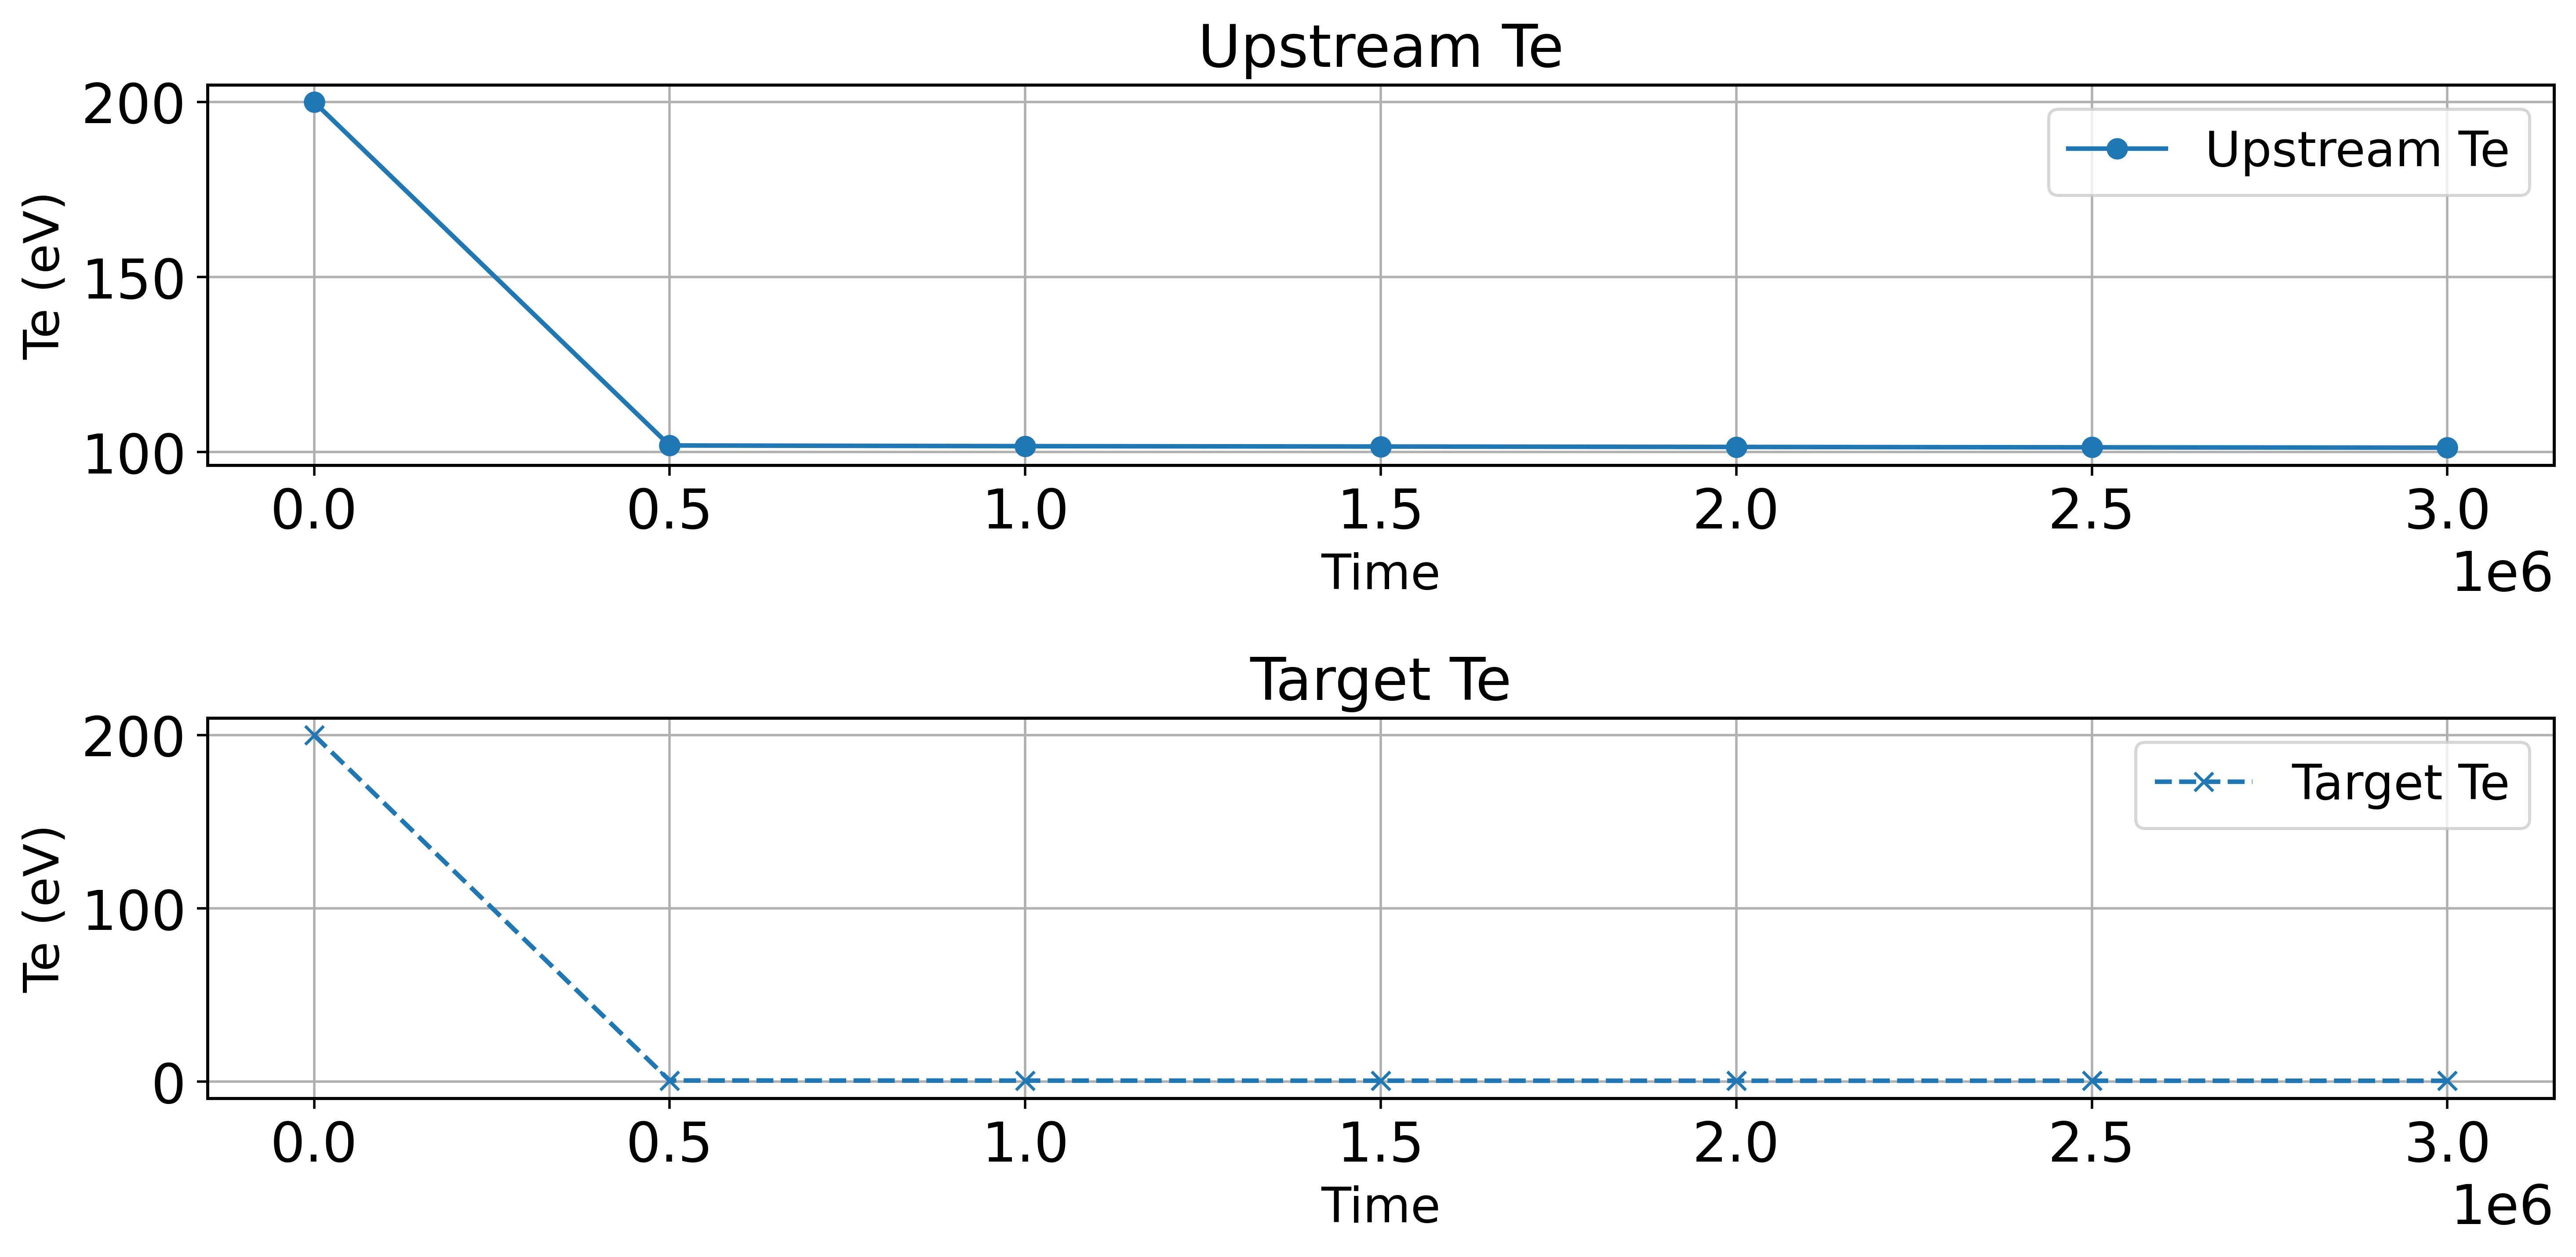

In [11]:
plot_time_history(ds_fl)

In [6]:
def find_first_below_threshold(temp_profile, y_values, threshold=5.0):
    """
    Finds the first location where the temperature drops below a given threshold.

    Parameters:
    temp_profile (np.array): The temperature profile along the spatial axis.
    y_values (np.array): The spatial locations corresponding to the temperature values.
    threshold (float): The temperature threshold to check against (default is 5 eV).

    Returns:
    float: The y-position where the temperature first drops below the threshold, or None if not found.
    """
    below_threshold = np.where(temp_profile < threshold)[0]
    
    if len(below_threshold) > 0:
        return y_values[below_threshold[0]]  # Return the first position
    else:
        return None  # Return None if no location is found below the threshold


def plot_time_history(dataset, variables=['Te'], upstream_index=2, target_index=-2, track_temp_position=False, time_slices = 200):
    """
    Plots the time history of user-specified variables at upstream and target positions
    on separate plots, using the last 200 time slices or the maximum available.
    
    Optionally tracks the first location where temperature drops below a threshold
    and adds it as a separate subplot.

    Parameters:
    dataset (xarray Dataset): Hermes-3 dataset.
    variables (list): List of variables to plot (e.g., ['Te', 'Td+', 'Ne']).
    upstream_index (int): Index for the upstream data.
    target_index (int): Index for the target data.
    track_temp_position (bool): If True, track the position where Te drops below 5 eV
                                and show it as a separate subplot.
    """
    # Determine how many time steps to plot (maximum 200 or the total available)
    num_time_slices = min(time_slices, dataset.sizes['t'])
    
    # Select the last `num_time_slices` time steps
    selected_steps = dataset.isel(t=slice(-num_time_slices, None))
    times = selected_steps['t'].values  # Corresponding time values

    # Adjust the number of subplots based on whether we're tracking Te < 5 eV position
    total_vars = len(variables) + (1 if track_temp_position else 0)

    # Create figure with subplots, one set for upstream and one for target, plus detachment front if enabled
    fig, axs = plt.subplots(2, total_vars, figsize=(12, 6), dpi=500)

    # Ensure axs is treated as a list if there's only one plot
    if total_vars == 1:
        axs = [axs[0], axs[1]]

    axs = np.ravel(axs)  # Flatten the axes for easy handling

    # Variable to store positions where Te first drops below 5 eV
    temp_drop_positions = [] if track_temp_position else None

    # If tracking the detachment front (Te < 5 eV), calculate it for each time slice
    if track_temp_position:
        drop_positions = []
        y_values = selected_steps['y'].values

        for t_step in range(num_time_slices):
            temp_profile = selected_steps['Te'].isel(t=t_step).values
            drop_position = find_first_below_threshold(temp_profile, y_values, threshold=5.0)
            drop_positions.append(drop_position)

        temp_drop_positions = np.array(drop_positions)

    # Iterate over each variable to plot upstream and target values
    for i, var in enumerate(variables):
        y_values = selected_steps['y'].values

        # Extract upstream and target data for each variable
        upstream_data = np.squeeze(selected_steps[var].isel(y=upstream_index).values)
        target_data = np.squeeze(selected_steps[var].isel(y=target_index).values)

        # Plot upstream data on the top row
        axs[i].plot(times, upstream_data, label=f'Upstream {var}', marker='o', linestyle='-')
        axs[i].set_title(f'Upstream {var}')
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel(f'{var} ({dataset[var].attrs.get("units", "Unknown units")})')
        axs[i].grid(True)
        axs[i].legend(loc='best')

        # Plot target data on the bottom row
        axs[i + total_vars].plot(times, target_data, label=f'Target {var}', marker='x', linestyle='--')
        axs[i + total_vars].set_title(f'Target {var}')
        axs[i + total_vars].set_xlabel('Time')
        axs[i + total_vars].set_ylabel(f'{var} ({dataset[var].attrs.get("units", "Unknown units")})')
        axs[i + total_vars].grid(True)
        axs[i + total_vars].legend(loc='best')

    # Add a separate subplot for the detachment front position if requested
    if track_temp_position:
        # Plot the tracked temperature drop position over time in the last subplot
        detachment_front_index = len(variables)  # The next index after all variables
        axs[detachment_front_index].plot(times, temp_drop_positions, marker='s', linestyle='-', color='red', label='Te < 5 eV Front')
        axs[detachment_front_index].set_title('Detachment Front Position (Te < 5 eV)')
        axs[detachment_front_index].set_xlabel('Time')
        axs[detachment_front_index].set_ylabel('Position (y)')
        axs[detachment_front_index].grid(True)
        axs[detachment_front_index].legend(loc='best')

        # Plot the same on the bottom row
        axs[detachment_front_index + total_vars].plot(times, temp_drop_positions, marker='s', linestyle='-', color='red', label='Te < 5 eV Front')
        axs[detachment_front_index + total_vars].set_title('Detachment Front Position (Te < 5 eV)')
        axs[detachment_front_index + total_vars].set_xlabel('Time')
        axs[detachment_front_index + total_vars].set_ylabel('Position (y)')
        axs[detachment_front_index + total_vars].grid(True)
        axs[detachment_front_index + total_vars].legend(loc='best')

    plt.tight_layout()
    plt.show()






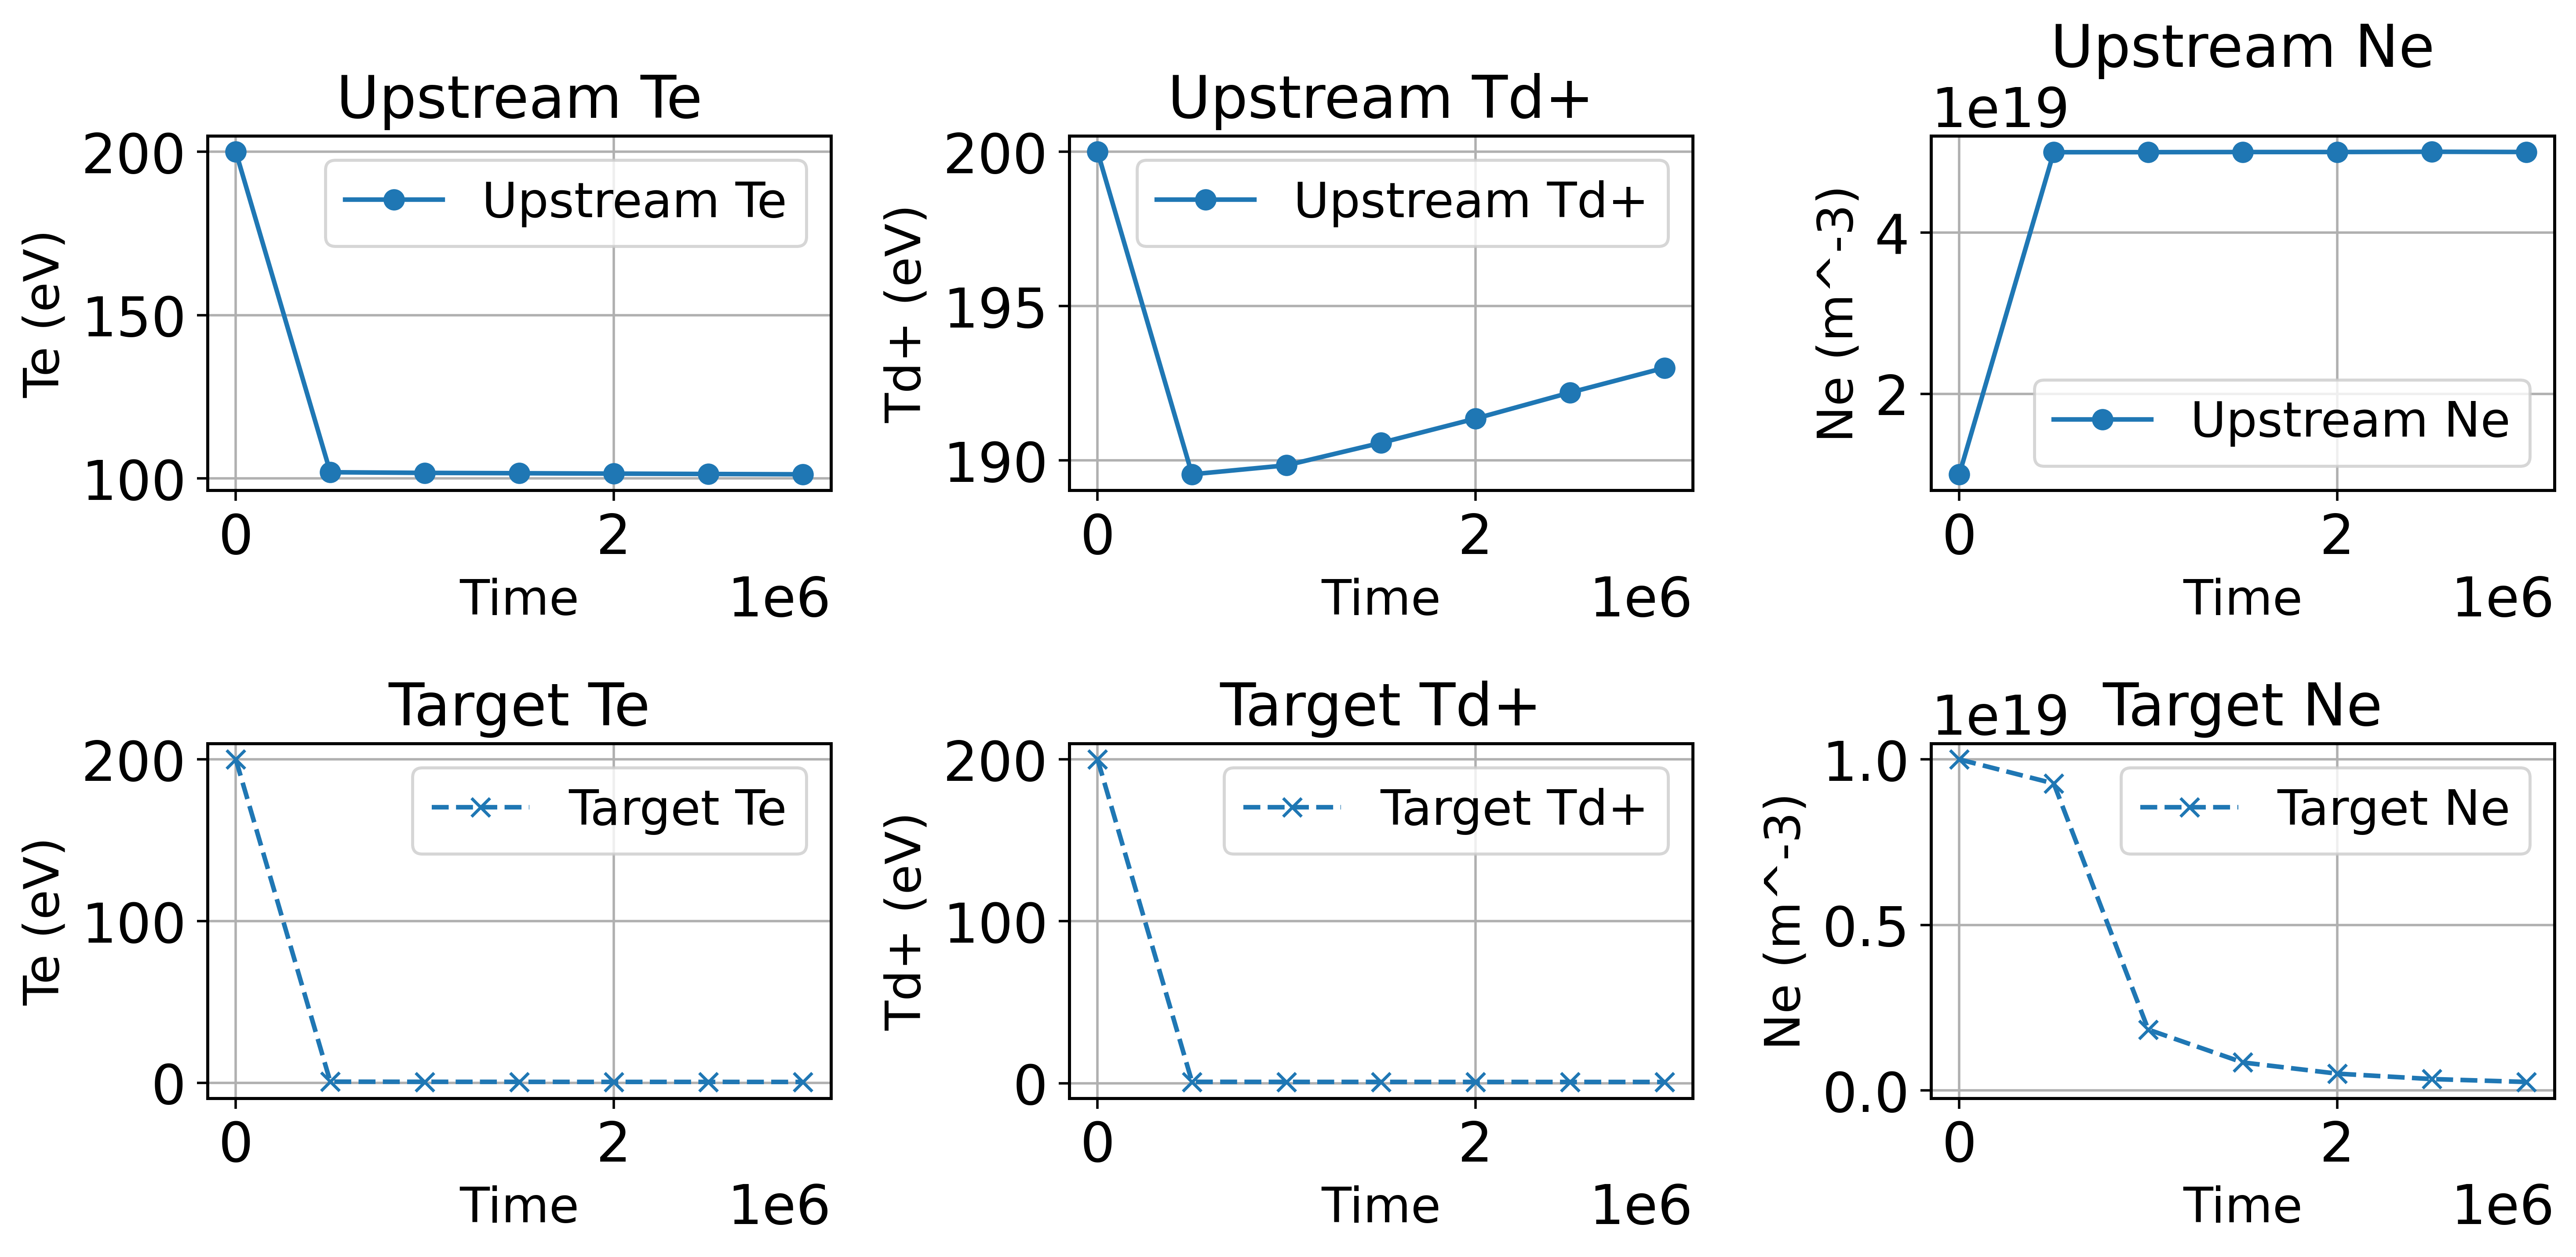

In [7]:
plot_time_history(ds_fl, variables=['Te', 'Td+', 'Ne'], time_slices = 3000)

In [10]:
def check_convergence(dataset):
    """
    Checks convergence for Hermes-3 by plotting profiles and time histories.

    Parameters:
    dataset (xarray Dataset): Hermes-3 dataset.
    """
    plot_latest_profiles(dataset)
    plot_time_history(dataset)

# Example usage:
# Assuming 'dataset' is an xarray Dataset object loaded with Hermes-3 simulation data
# check_convergence(dataset)


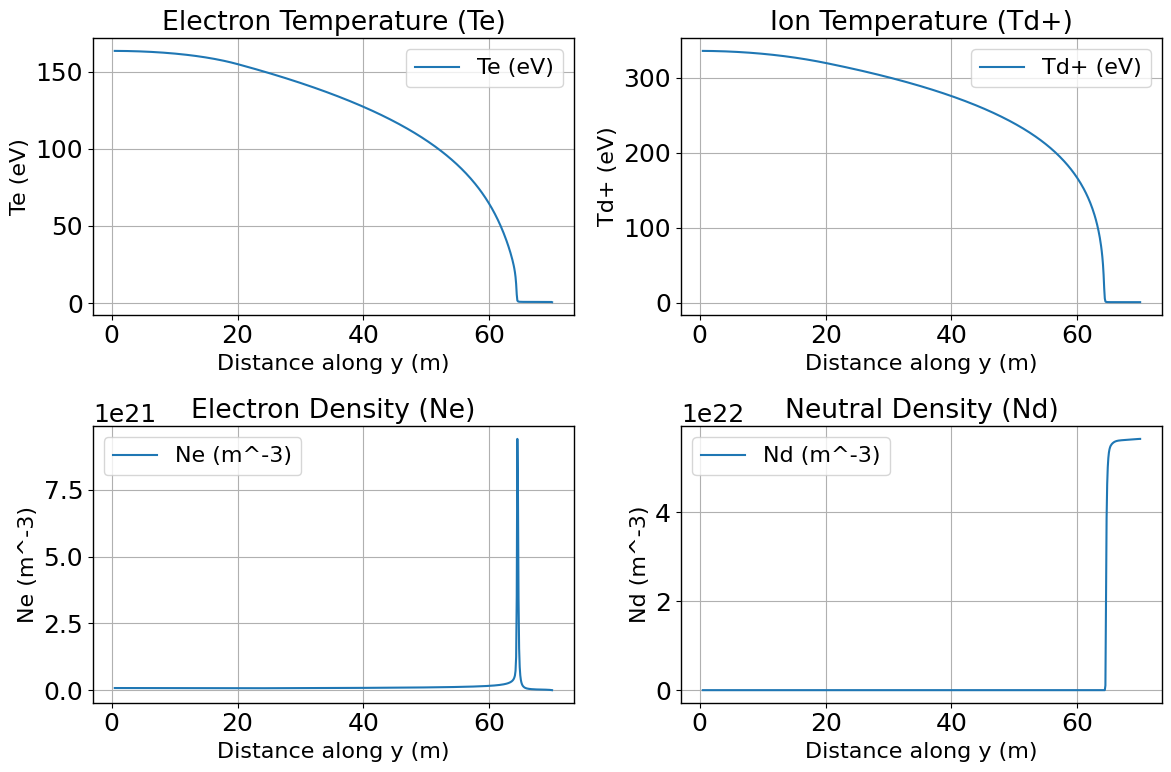

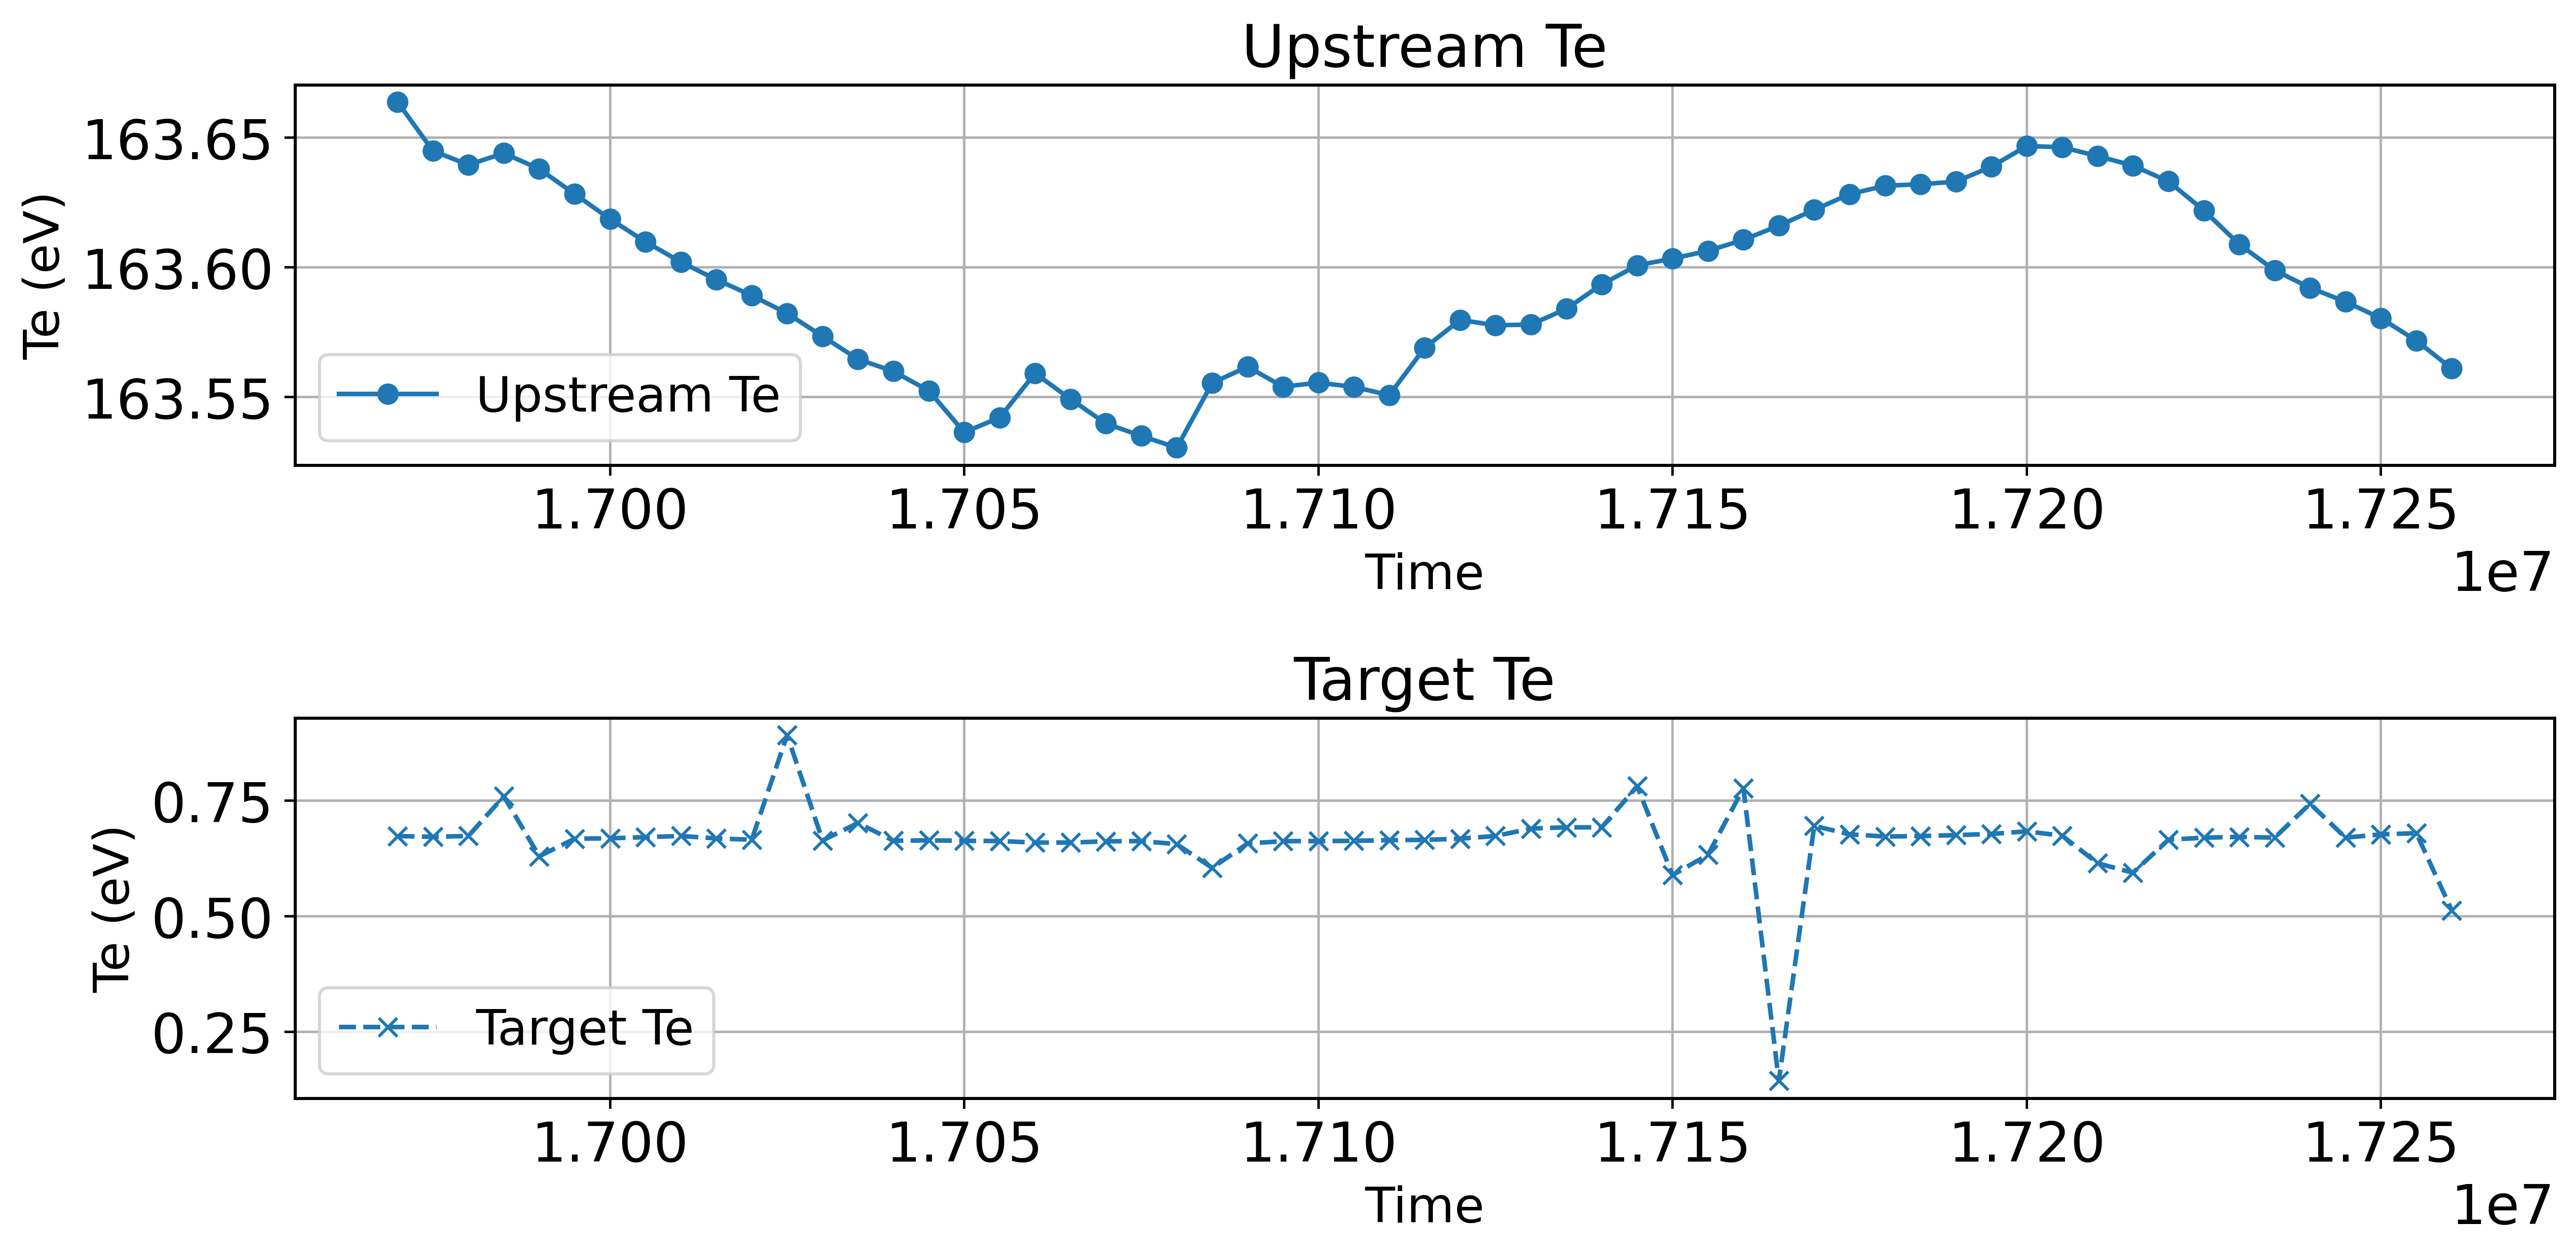

In [11]:
check_convergence(ds_fl)